In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm_notebook
import pickle

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
df = pd.read_csv("Py_Dataset.csv")
staz = pd.read_csv("Stazioni_Emilia.csv")
dummies = pd.get_dummies(df.Tipo)

In [3]:
normal_cluster = """
data {
    int<lower=0> N; 
    int<lower=0> p;
    int<lower=0> G;
    int<lower=0> C;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    int stazione[N];
    real omega;
    row_vector[2] coord[G];
}

parameters {
    
    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    matrix[G, 5] A;
    
    vector[G] w;
    real<lower=0> rho;
    real<lower=0> alpha;
    
    
    vector<lower=0>[C] sigma_l_sq;
    matrix[C,5] mu_l;
    simplex[C] eta;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector<lower=0>[C] sigma_l;
    sigma_l = sqrt(sigma_l_sq);
    
    vector[N] ft;
    ft[1:N] = A[stazione[1:N], 5];
    ft[1:N] += (  rows_dot_product(A[stazione[1:N],1],sin(omega*t[1:N])) 
                + rows_dot_product(A[stazione[1:N],2],cos(omega*t[1:N]))
                + rows_dot_product(A[stazione[1:N],3],sin(3*omega*t[1:N])) 
                + rows_dot_product(A[stazione[1:N],4],cos(3*omega*t[1:N]))  );

    vector[N] mu;
    mu = ft + X*beta ;
    mu[1:N] += w[stazione[1:N]];
         
    cov_matrix[G] H = cov_exp_quad(coord, alpha, rho);
}


model {  

    sigma_sq ~ inv_gamma(3,2);
    
    beta ~ normal([-0.1, -0.1, 0.1], 1);
    
    rho ~ beta(10, 2000);
    
    w ~ multi_normal(rep_vector(0,G),H);
    
    Y ~ normal(mu, sigma);  
    
    eta ~ dirichlet(rep_vector(1, C));
    
    for (i in 1:C){
         mu_l[i, :] ~ multi_normal(rep_vector(0,5), diag_matrix(rep_vector(1,5)));
         }
         
    sigma_l_sq ~ inv_gamma(10,9);
    
    
    for (g in 1:G){
        vector[C] lps = log(eta);
        for (k in 1:C)
            lps[k] += normal_lpdf(A[g, :] | mu_l[k,:], sigma_l[k]);
        target += log_sum_exp(lps);
        }
}


generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
  
  
  int cluster_allocs[G];
  for(g in 1:G){
  // kernel discreta di i in k
  vector[C] log_probs = log(eta);
  for (k in 1:C)
     log_probs[k] += normal_lpdf(A[g, :] | mu_l[k,:], sigma_l[k]);
  cluster_allocs[g] = categorical_rng(softmax(log_probs));
  }
  
}
"""

stan_file = "./normal_cluster.stan"

with open(stan_file, "w") as f:
    print(normal_cluster, file=f)

normal_cluster = CmdStanModel(stan_file=stan_file)


INFO:cmdstanpy:compiling stan program, exe file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_cluster
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
Warning in '/Users/michelafrigeri/JupyterProjects/PROGETTO/normal_cluster.stan', line 54, column 22: cov_exp_quad is deprecated and will be removed in the future. Use gp_exp_quad_cov instead.
INFO:cmdstanpy:compiled model file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_cluster


In [4]:
y = np.array(df.Y_log)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
stazione = np.array(df.id)
omega = 2*np.pi/365
coord = np.matrix( pd.concat([staz.Lat, staz.Long], axis=1) )

N = len(y)
p = 3   # Quota + Tipo(2 dummies)
G = 49  # numero stazioni in Emilia-Romagna
C = 10  # numero cluster

In [5]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "p": p,   # 4
    "G": G,
    "C": C,
    
    "Y": y,
    "X": x, 
    "t": t,
    "stazione": stazione,
    "omega": omega,
    "coord": coord
}

fit_clust = normal_cluster.sample(data=reg_data, chains=2, parallel_chains=2, 
                             iter_warmup=700, iter_sampling=1300, show_progress=True)



Chain 2 -   done: 100%|███████████████████| 3000/3000 [3:28:05<00:00,  4.16s/it]


In [6]:
normal_az = az.from_cmdstanpy(fit_clust)

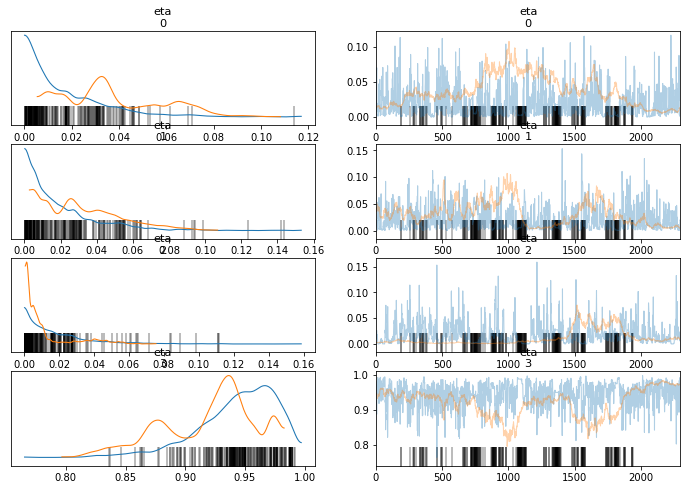

In [7]:
az.plot_trace(normal_az, var_names=["eta"], compact=False)
plt.show()

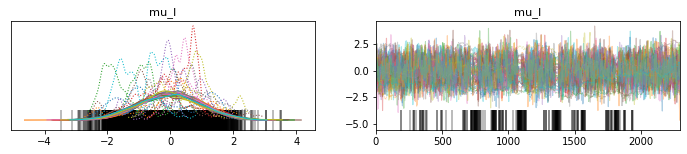

In [24]:
az.plot_trace(normal_az, var_names=["mu_l"], compact=True)
plt.show()


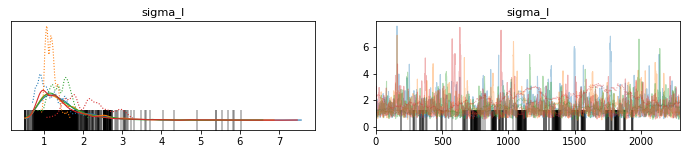

In [25]:
az.plot_trace(normal_az, var_names=["sigma_l"], compact=True)
plt.show()

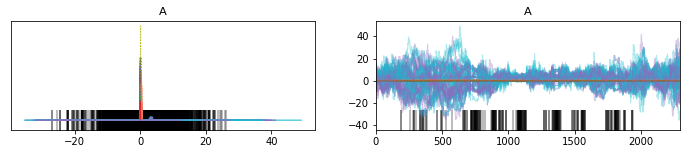

In [37]:
az.plot_trace(normal_az, var_names=["A"], compact=True)
plt.show()

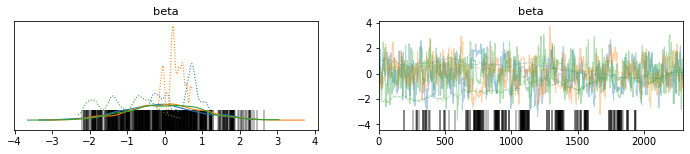

In [38]:
az.plot_trace(normal_az, var_names=["beta"], compact=True)
plt.show()

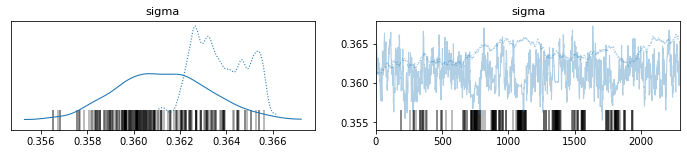

In [39]:
az.plot_trace(normal_az, var_names=["sigma"], compact=True)
plt.show()

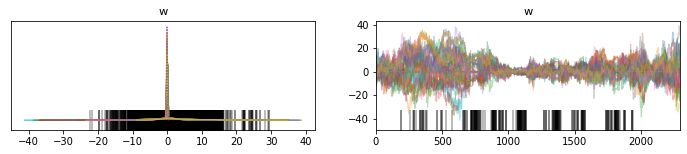

In [40]:
az.plot_trace(normal_az, var_names=["w"], compact=True)
plt.show()

In [10]:
# cluster allocation
output_clust = fit_clust.stan_variable('cluster_allocs')
np.min(output_clust)
output_clust.shape

(4600, 49)

In [44]:
# prima iterazione : 1st chain
output_clust[0,:]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [15]:
# ultima iterazione : 1st chain
output_clust[1299,:] 

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [ ]:
# prima iterazione : 2nd chain
output_clust[1300,:]

In [ ]:
# ultima iterazione : 2nd chain
output_clust[2599,:] 